In [1]:
from contrastive import CPCA
from copy import copy
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from pyensembl import ensembl_grch38
from rpca import R_pca
import scipy
from scipy.linalg import svd
from sklearn.decomposition import PCA, SparsePCA, FastICA
from sklearn.metrics import silhouette_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import label_binarize
from supervisedPCA import supervised_pca
import time

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Utility functions.
def to_one_hot_one_feature(U):
    """ Assumes U has a single feature.
    Returns matrix of size U.shape[0], number_unique + 1
    """
    as_set = set(U)
    print(as_set)
    set_as_list = list(as_set)
    one_hot = np.zeros((U.shape[0], len(as_set)))
    for i in range(U.shape[0]):
        one_hot[i, set_as_list.index(U[i])] = 1
    return one_hot

def load_data(data_dir, split_by):
    fg_data = np.load("{}cases.npy".format(data_dir))
    bg_data = np.load("{}controls.npy".format(data_dir))
    matches = np.load("{}matches.npy".format(data_dir))
    try:
        stages  = np.load("{}cases_stages.npy".format(data_dir))
    except FileNotFoundError:
        stages = np.array([])
    if split_by == "Stage":
        bg_data = np.squeeze(fg_data[np.where(stages == "stage iv"), :])
        fg_data = np.squeeze(fg_data[np.where(stages == "stage i"), :])
        print(bg_data.shape)
        print(fg_data.shape)
        matches = []
        fname_base = "stage"
    return fg_data, bg_data, matches, stages

In [31]:
plt.rcParams['savefig.dpi'] = 300
cancer_type = "BRCA"
split_by = "Case_Control"

test_case_control = True
test_tissue_type = False

if test_tissue_type:
    fname_base = "tissue_type"
elif test_case_control:
    fname_base = "case_control"
else:
    fname_base = "stage"

plot_clusters = True
calc_onc_selection = True
plot_selection = (True and calc_onc_selection)
write_enrichment = True
plot_singular_values = False

add_unmatched = cancer_type in ["GBM", "Combined"] # only add unmatched for GBM/combined due to lack of matched samples
pct_train = 0.6
split_in_order = False

In [32]:
data_dir = "{}/".format(cancer_type)
foreground_data, background_data, matches, stages = load_data(data_dir, split_by)
n_fg = len(foreground_data)
n_bg = len(background_data)
transcript_names = np.load("transcript_names.npy")
print(n_fg, n_bg, len(transcript_names))

1102 113 60483


In [33]:
# Convert transcript names into gene names.
transcript_names_converted = []
class Nil(object):
    pass
not_found = Nil()
not_found.gene_name = "Not Found"
for i, t_id in enumerate(transcript_names):
    try:
        transcript_names_converted.append(ensembl_grch38.gene_by_id(t_id[2:-3]))
    except ValueError:
        transcript_names_converted.append(not_found)
        foreground_data[:, i] = 0.
        background_data[:, i] = 0.
transcript_names = np.array(transcript_names_converted)

In [34]:
# Organize data.
fg_mask = np.std(foreground_data, axis=0) > 1e-1
bg_mask = np.std(background_data, axis=0) > 1e-1
mask = np.logical_and(fg_mask, bg_mask)
name_mask = np.array([x != not_found for x in transcript_names])
mask = np.logical_and(mask, name_mask)
foreground_data = foreground_data[:, mask]
background_data = background_data[:, mask]
transcript_names = transcript_names[mask]
n_transcripts = 50000
foreground_data = foreground_data[:, :n_transcripts]
background_data = background_data[:, :n_transcripts]
transcript_names = transcript_names[:n_transcripts]
print(foreground_data.shape)
print(background_data.shape)

from sklearn.preprocessing import normalize
combined = np.vstack((foreground_data, background_data))
combined_normed = normalize(combined, axis=1)
combined_normed = normalize(combined_normed, axis=0)
del combined
foreground_data = combined_normed[:n_fg]
background_data = combined_normed[n_fg:]

if split_in_order:
    n_train_fg = int(pct_train*n_fg)
    n_train_bg = int(pct_train*n_bg)
    n_train_fg = len(fg_data_brca)
    n_train_bg = len(bg_data_brca)
    train_fg_idxs = np.array(range(n_train_fg))
    train_bg_idxs = np.array(range(n_train_bg))
    test_fg_idxs  = np.array(range(n_train_fg, n_fg))
    test_bg_idxs  = np.array(range(n_train_bg, n_bg))
    n_test_fg = len(test_fg_idxs)
    n_test_bg = len(test_bg_idxs)
else:
    train_fg_idxs, test_fg_idxs = train_test_split(list(range(n_fg)), test_size=1-pct_train)
    train_bg_idxs, test_bg_idxs = train_test_split(list(range(n_bg)), test_size=1-pct_train)
    n_train_fg = len(train_fg_idxs)
    n_test_fg  = len(test_fg_idxs)
    n_train_bg = len(train_bg_idxs)
    n_test_bg  = len(test_bg_idxs)

(1102, 15584)
(113, 15584)


In [35]:
max_n_components = 25
train_fg = foreground_data[train_fg_idxs]
train_bg = background_data[train_bg_idxs]
test_fg  = foreground_data[test_fg_idxs]
test_bg  = background_data[test_bg_idxs]
train_data = np.vstack((train_fg, train_bg))
test_data  = np.vstack((test_fg,  test_bg))
train_labels = np.ravel(np.vstack((np.ones((n_train_fg, 1)), np.zeros((n_train_bg, 1)))))
test_labels = np.ravel(np.vstack((np.ones((n_test_fg, 1)), np.zeros((n_test_bg, 1)))))

In [36]:
# Make differential dataset
differential = np.zeros((1, foreground_data.shape[1]))
if len(matches) > 0:
    print("****Matched****")
    differential = np.array([foreground_data[i] - background_data[j] for [j, i] in matches if i in train_fg_idxs and j in train_bg_idxs])
    differential = np.vstack((differential, np.zeros_like(differential)))
if add_unmatched:
    n_differential = 750
    print("****Adding {} unmatched differences****".format(n_differential))
    unmatched = np.array([foreground_data[np.random.choice(train_fg_idxs)] - background_data[np.random.choice(train_bg_idxs)] for _ in range(n_differential)])
    unmatched = np.vstack((unmatched, np.zeros_like(unmatched)))
    differential = np.vstack((differential, unmatched))

differential = normalize(differential, axis=1)
differential = normalize(differential, axis=0)

****Matched****


In [37]:
if cancer_type == "Combined":
    train_cancer_types = cancer_types_fg[train_fg_idxs]
    test_cancer_types  = cancer_types_fg[test_fg_idxs]

if not test_case_control and not test_tissue_type:
    stages_parsed = np.zeros((len(stages), 5))
    for i, stage in enumerate(stages):
        stage = stage[0]
        if "stage iv" in stage.lower():
            stages_parsed[i, :] = np.array([0, 0, 0, 0, 1])
        elif "stage iii" in stage.lower():
            stages_parsed[i, :] = np.array([0, 0, 0, 1, 0])
        elif "stage ii" in stage.lower():
            stages_parsed[i, :] = np.array([0, 0, 1, 0, 0])
        elif "stage i" in stage.lower():
            stages_parsed[i, :] = np.array([0, 1, 0, 0, 0])
        else:
            stages_parsed[i, :] = np.array([1, 0, 0, 0, 0])

    stages = stages_parsed
    train_stages = stages[train_fg_idxs]
    test_stages  = stages[test_fg_idxs]
    train_stages = np.argmax(train_stages, axis=1)
    test_stages = np.argmax(test_stages, axis=1)
    print(train_stages.shape)
    print(test_stages.shape)

def get_differential(data, numComponents=None):
        m, n = data.shape
        data -= data.mean(axis=0)

        pca = PCA(n_components=numComponents)
        data_components = pca.fit_transform(data)
        return data_components, pca.singular_values_, pca.components_.T
        """
        print("Calculating cov")
        R = np.cov(data, rowvar=False)
        print("Finished cov")
        # use 'eigh' rather than 'eig' since R is symmetric,
        # the performance gain is substantial
        evals, evecs = np.linalg.eigh(R)
        print("Finished eigh.")
        idx = np.argsort(evals)[::-1]
        evecs = evecs[:,idx]
        evals = evals[idx]
        if numComponents is not None:
            evecs = evecs[:, :numComponents]
        # carry out the transformation on the data using eigenvectors
        # and return the re-scaled data, eigenvalues, and eigenvectors
        return np.dot(evecs.T, data.T).T, evals, evecs
        """

In [20]:
# Fit All Dim Reduction Methods.

# Normal PCA
print("Fitting PCA...", end='')
t = time.time()
pca = PCA(n_components=max_n_components)
pca_train_reduced = pca.fit_transform(train_data)
print("Took {:.3f} seconds".format(time.time() - t))
pca_test_reduced = pca.transform(test_data)
pca_components = pca.components_
pca_sing = pca.singular_values_


print("Fitting ICA...", end='')
t = time.time()
ica = FastICA(n_components=max_n_components)
ica_train_reduced = ica.fit_transform(train_data)
print("Took {:.3f} seconds".format(time.time() - t))
ica_test_reduced  = ica.transform(test_data)
ica_components    = ica.components_.copy()

print("Fitting CCA...", end='')
import sys
t = time.time()
from sklearn.cross_decomposition import CCA
ccas = []
cca_train_reduced = np.zeros((train_data.shape[0], max_n_components))
cca_components    = np.zeros((max_n_components, train_data.shape[1]))
cur_reps_cca      = np.zeros_like(train_data)
for i in range(max_n_components):
    sys.stdout.flush()
    print(i, end='')
    cca = CCA(n_components=1, scale=True)
    data_to_reduce = train_data-cur_reps_cca
    if data_to_reduce.shape[1] > 50:
        pca_cca = PCA(n_components=50)
        data_to_reduce = pca_cca.fit_transform(data_to_reduce)
    cca.fit(data_to_reduce, train_labels)
    cca_components[i, :] = np.squeeze(cca.x_weights_.T.dot(pca_cca.components_))
    cca_train_reduced[:, i] = np.squeeze(train_data.dot(np.expand_dims(cca_components[i, :], 1)))
    cur_reps_cca += np.expand_dims(cca_train_reduced[:, i], 1).dot(np.expand_dims(cca_components[i, :], 1).T)
    ccas.append(copy(cca))
print("Took {:.3f} seconds".format(time.time() - t))
cca_test_reduced  = np.array([np.squeeze(test_data.dot(np.expand_dims(cca_components[i, :], 1))) for i in range(max_n_components)]).T

print("Fitting LDA...", end='')
t = time.time()
ldas = []
pca_ldas = []
lda_train_reduced = np.zeros((train_data.shape[0], max_n_components))
lda_components    = np.zeros((max_n_components, train_data.shape[1]))
cur_reps_lda      = np.zeros_like(train_data)
for i in range(max_n_components):
    sys.stdout.flush()
    print(i, end='')
    lda = LDA(n_components=1)
    data_to_reduce = train_data-cur_reps_lda
    if data_to_reduce.shape[1] > 100:
        pca_lda = PCA(n_components=100)
        data_to_reduce = pca_lda.fit_transform(data_to_reduce)
        pca_ldas.append(pca_lda)
    lda_train_reduced[:, i] = np.squeeze(lda.fit_transform(data_to_reduce, train_labels))
    lda_components[i, :]    = lda.scalings_.T.dot(pca_lda.components_)
    cur_reps_lda += np.expand_dims(lda_train_reduced[:, i], 1).dot(np.expand_dims(lda_components[i, :], 1).T)
    ldas.append(copy(lda))
print("Took {:.3f} seconds".format(time.time() - t))
lda_test_reduced  = np.zeros((test_data.shape[0], max_n_components))
cur_reps = np.zeros_like(test_data)
for i in range(max_n_components):
    lda_test_reduced[:, i] = np.squeeze(ldas[i].transform(pca_ldas[i].transform(test_data - cur_reps)))
    cur_reps += np.expand_dims(lda_test_reduced[:, i], 1).dot(np.expand_dims(lda_components[i, :], 1).T)

print("Fitting SupPCA...", end='')
t = time.time()
sup_pca = supervised_pca.SupervisedPCAClassifier(n_components=max_n_components)
sup_pca.fit(train_data, train_labels)
sup_train_reduced = sup_pca.get_transformed_data(train_data)
sup_test_reduced  = sup_pca.get_transformed_data(test_data)
sup_components    = sup_pca.get_components()
print("Took {:.3f} seconds".format(time.time() - t))

print("Fitting PLS...", end='')
t = time.time()
plsr = PLSRegression(n_components=max_n_components, scale=True)
plsr.fit(train_data, train_labels)
plsr_train_reduced = plsr.x_scores_
plsr_test_reduced  = plsr.transform(test_data)
plsr_components    = plsr.x_weights_.T # n_components x n_features
print("Took {:.3f} seconds".format(time.time() - t))

# Contrastive PCA
print("Fitting cPCA...", end='')
t = time.time()
mdl = CPCA(n_components=max_n_components)
cpca_preprocess = PCA(n_components=500)
train_data_preprocessed = cpca_preprocess.fit_transform(train_data)
test_data_preprocessed = cpca_preprocess.transform(test_data)
cpca_preprocess_components = cpca_preprocess.components_.copy()
cpca_train_fg_reduced, alpha = mdl.fit_transform(train_data_preprocessed[:n_train_fg], train_data_preprocessed[n_train_fg:],
    n_alphas=1, n_alphas_to_return=1, return_alphas=True)
alpha = alpha[0]
print("Took {:.3f} seconds".format(time.time() - t))
cpca_train_fg_reduced = cpca_train_fg_reduced[0]
cpca_train_bg_reduced = mdl.transform(train_data_preprocessed[n_train_fg:])[0]
cpca_train_reduced = np.vstack((cpca_train_fg_reduced, cpca_train_bg_reduced))
cpca_test_reduced = mdl.transform(test_data_preprocessed)[0]
pca = PCA(n_components=max_n_components)
pca.fit(mdl.fg_cov - alpha*mdl.bg_cov)
cpca_components = pca.components_.dot(cpca_preprocess_components)

print("Fitting rPCA...", end='')
t = time.time()
rpca = R_pca(train_data)
L, S = rpca.fit(max_iter=5000, iter_print=100)
_, rpca_evals, rpca_evecs = get_differential(L, max_n_components)
rpca_components = rpca_evecs.T
rpca_train_reduced = train_data.dot(rpca_evecs)
rpca_test_reduced  = test_data.dot(rpca_evecs)
print("Took {:.3f} seconds.".format(time.time() - t))

print("Fitting dPCA...", end='')
t = time.time()
dpca = PCA(n_components=max_n_components)
dpca.fit(differential)
print("Took {:.3f} seconds.".format(time.time() - t))
dpca_train_reduced = dpca.transform(train_data)
dpca_test_reduced  = dpca.transform(test_data)
dpca_components = dpca.components_.copy()
diff_sing = dpca.singular_values_.copy()


print("Fitting dsPCA...", end='')
t = time.time()
drpca_pca = PCA(n_components=100)
differential_pca = drpca_pca.fit_transform(differential)
dspca = SparsePCA(n_components=max_n_components, max_iter=10,
    verbose=False, alpha=10, ridge_alpha=0.01)
dspca.fit(differential_pca)
dspca_components = dspca.components_.dot(drpca_pca.components_)
dspca_train_reduced = train_data.dot(dspca_components.T)
dspca_test_reduced  = test_data.dot(dspca_components.T)
print("Took {:.3f} seconds.".format(time.time() - t))


# drPCA
print("Fitting drPCA...", end='')
t = time.time()
rpca = R_pca(differential_pca)
L, S = rpca.fit(max_iter=5000, iter_print=100)
print(L)
_, drpca_evals, drpca_evecs = get_differential(L, max_n_components)
drpca_components = drpca_evecs.T.dot(drpca_pca.components_)
drpca_train_reduced = train_data.dot(drpca_components.T)
drpca_test_reduced  = test_data.dot(drpca_components.T)
print("Took {:.3f} seconds.".format(time.time() - t))

reduced = [(pca_train_reduced, pca_test_reduced, pca_components, "PCA"),
    (rpca_train_reduced, rpca_test_reduced, rpca_components, "rPCA"),
    (ica_train_reduced, ica_test_reduced, ica_components, "ICA"),
    (cpca_train_reduced, cpca_test_reduced, cpca_components,  "cPCA"),
    (sup_train_reduced, sup_test_reduced, sup_components, "Sup. PCA"),
    (cca_train_reduced, cca_test_reduced, cca_components, "CCA"),
    (plsr_train_reduced, plsr_test_reduced, plsr_components, "PLS-DA"),
    (lda_train_reduced, lda_test_reduced, lda_components, "LDA"),
    (dpca_train_reduced, dpca_test_reduced, dpca_components, "dPCA"),
    (drpca_train_reduced, drpca_test_reduced, drpca_components, "drPCA")
    ]

Fitting PCA...Took 0.708 seconds
Fitting ICA...Took 1.778 seconds
Fitting CCA...0123456789101112131415161718192021222324Took 26.457 seconds
Fitting LDA...0123456789101112131415161718192021222324Took 28.720 seconds
Fitting SupPCA...Took 9.701 seconds
Fitting PLS...Took 1.511 seconds
Fitting cPCA...Took 4.889 seconds
Fitting rPCA...iteration: 1, error: 0.0020781565744275154
iteration: 2, error: 8.749248629129222e-09
Took 9.532 seconds.
Fitting dPCA...Took 0.097 seconds.
Fitting dsPCA...Took 0.352 seconds.
Fitting drPCA...iteration: 1, error: 523.0787720679882
iteration: 61, error: 0.0012817048170970134
[[-4.13787813e-02  6.54424263e-01 -5.29345781e-01 ... -1.18754392e-22
  -8.18000300e-23 -1.10425190e-19]
 [-7.04734603e-02  1.09923360e+00 -1.04384651e-01 ... -6.76769945e-24
  -1.39341913e-24 -5.77909044e-19]
 [ 6.64523669e-01  2.23760765e+00 -3.10950338e-01 ...  9.36846247e-23
   1.43543650e-22  9.03606259e-19]
 ...
 [-2.30020055e-01 -2.46938154e+00  9.44109530e-01 ...  1.44401653e-23
  

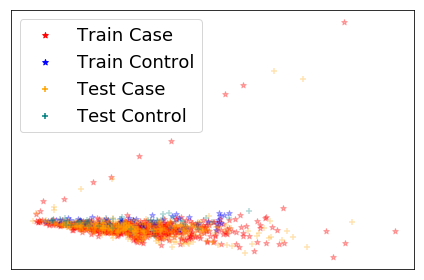

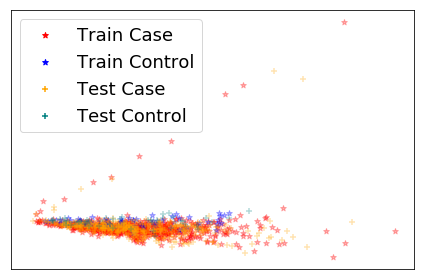

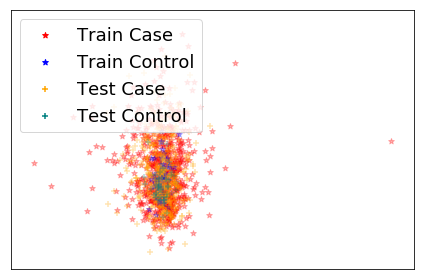

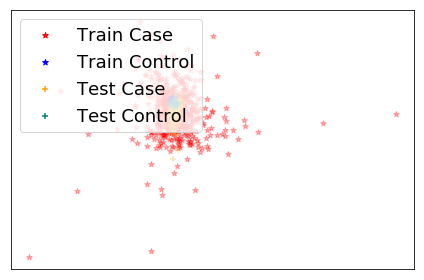

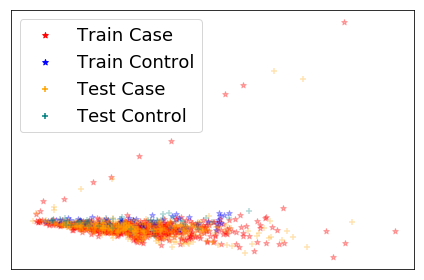

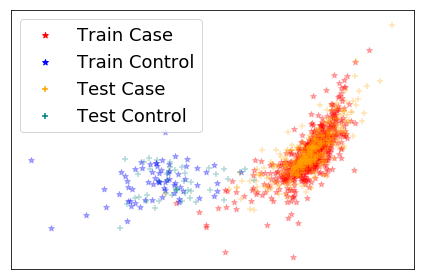

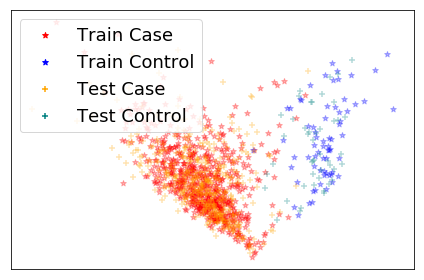

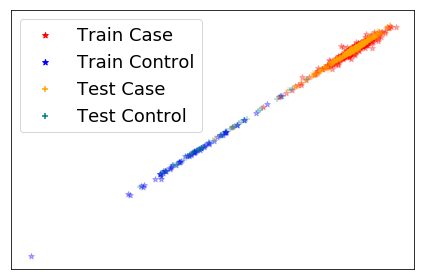

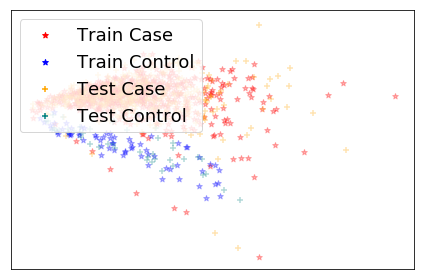

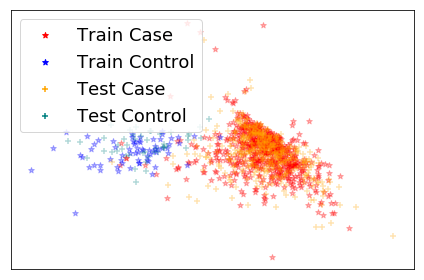

In [21]:
def plot_clusts(fg_train, bg_train, fg_test, bg_test, name):
    fig = plt.figure()
    plt.scatter(fg_train[:, 0], fg_train[:, 1], marker='*', color='red', label='Train Case', alpha=0.3)
    plt.scatter(bg_train[:, 0], bg_train[:, 1], marker='*', color='blue', label='Train Control', alpha=0.3)
    plt.scatter(fg_test[:, 0], fg_test[:, 1], marker='+', color='orange', label='Test Case', alpha=0.3)
    plt.scatter(bg_test[:, 0], bg_test[:, 1], marker='+', color='teal', label='Test Control', alpha=0.3)
    points = np.vstack((fg_test, bg_test))
    #plt.annotate("Test Sil: {:.3f}".format(silhouette_score(points, test_labels)),
    #    (np.min(points[:, 0]), np.max(points[:, 1])))
    plt.xticks([])
    plt.yticks([])
    lgd = plt.legend(fontsize=18, loc='upper left')
    for lh in lgd.legendHandles:
        lh.set_alpha(1.0)
    plt.tight_layout()
    plt.savefig("{}/Results/Clusters/{}_{}.png".format(cancer_type, fname_base, name))

if plot_clusters:
    helper = lambda train, test, name: plot_clusts(train[:n_train_fg, :2], train[n_train_fg:, :2],
                                            test[:n_fg-n_train_fg, :2], test[n_fg-n_train_fg:, :2], name)
    for (train, test, components, name) in reduced:
        helper(train, test, name)

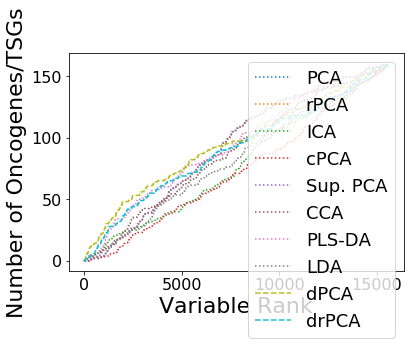

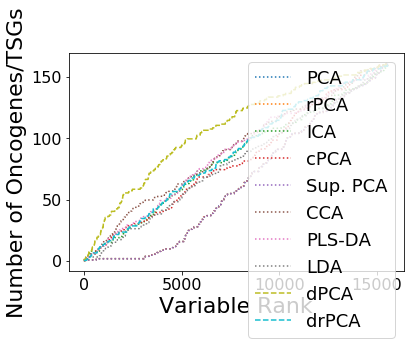

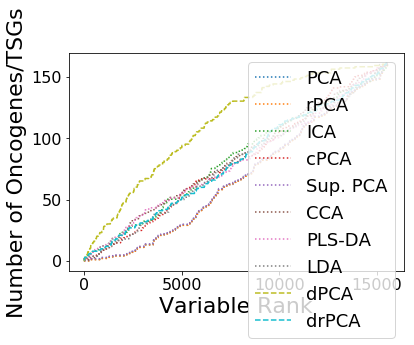

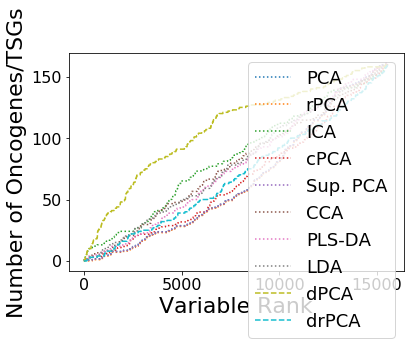

In [38]:
# Plot the Rank Curve
cosmic_genes = set([])
with open("cosmic_gene_census.tsv", 'r') as gene_census:
    for line in gene_census:
        cosmic_genes.add(line.split('\t')[0].upper())

def generate_curve(sorted_list):
    counts = []
    count = 0
    for (i, val) in sorted_list:
        if transcript_names[i].gene_name.upper() in cosmic_genes:
            count += 1
        counts.append(count)
    return counts

def plot_list_top(n):
    sort_helper = lambda components: [i for i in sorted(enumerate(np.sum(components[:n], axis=0)), key=lambda x: np.abs(x[1]), reverse=True)]
    sorted_components = [sort_helper(components) for (train, test, components, name) in reduced]

    def write_to_file(sorted_components, name):
        os.makedirs("{}/Results/Components/{}".format(cancer_type, name), exist_ok=True)
        with open("{}/Results/Components/{}/{}_{}_top_{}.csv".format(cancer_type, name, fname_base, name, n), 'w') as csv_file:
            with open("{}/Results/Components/{}/{}_{}_top_{}.tsv".format(cancer_type, name, fname_base, name, n), 'w') as tsv_file:
                for (idx, magnitude) in sorted_components:
                    print("{},{}".format(transcript_names[idx].gene_name, magnitude), file=csv_file)
                    print("{}\t{}".format(transcript_names[idx].gene_name, magnitude), file=tsv_file)

    if write_enrichment:
        for i, comps in enumerate(sorted_components):
            write_to_file(comps, reduced[i][-1])

    if plot_selection:
        fig = plt.figure()
        helper = lambda counts, name, linestyle: plt.plot(counts, label=name, linestyle=linestyle)
        for i, comps in enumerate(sorted_components):
            name = reduced[i][-1]
            if name == "drPCA" or name == "dsPCA" or name == "dPCA" or name == "dICA":
                helper(np.array(generate_curve(comps)) + np.random.uniform(0, 1), name, 'dashed')
            else:
                helper(np.array(generate_curve(comps)) + np.random.uniform(0, 1), name, 'dotted')
        plt.xlabel("Variable Rank", fontsize=22)
        plt.ylabel("Number of Oncogenes/TSGs", fontsize=22)
        ax = plt.gca()
        ax.tick_params(labelsize=16)
        plt.legend(fontsize=18)
        plt.savefig("{}/Results/oncogene_selection_top_{}_{}".format(cancer_type, n, fname_base))
    return sorted_components

if calc_onc_selection:
    sorted_components = plot_list_top(1)
    plot_list_top(2)
    plot_list_top(3)
    plot_list_top(5)

In [29]:
from sklearn.model_selection import RandomizedSearchCV
def calc_predictive(n_components=5):
    helper = lambda reps, labels, name: print("{}: {:.3f}".format(name,
        silhouette_score(reps[:, :n_components], labels)))
    print("="*20)
    print("Silhouette Scores, Training Data:")
    for (train, test, comps, name) in reduced:
        helper(train, train_labels, name)
    
    print('-'*20)
    print("Silhouette Scores, Testing Data:")
    for (train, test, comps, name) in reduced:
        helper(test, test_labels, name)
    print("="*20)

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start= 2, stop = 15, num = 3)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 20, num=5)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    C_list = [0.01, 0.1, 0.5, 1., 2.5, 5.0, 10., 25.]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    lr_grid = {'C': C_list}
    def predict(x_train, x_test, y_train, y_test, calc_random):
        rf = RandomForestClassifier(n_estimators=3)
        clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
            n_iter=8, cv=2, verbose=0)

        clf.fit(x_train, y_train)
        #cross_validate(clf, x_train, y_train, return_train_score=False)

        if not test_tissue_type and not test_case_control:
            binarize = lambda x: label_binarize(x, classes=[0, 1, 2, 3, 4])
            auc_train = np.mean([roc_auc_score(binarize(y_train)[:, i], binarize(clf.predict(x_train))[:, i]) for i in range(5)])
            auc = np.mean([roc_auc_score(binarize(y_test)[:, i], binarize(clf.predict(x_test))[:, i]) for i in range(5)])
        else:
            auc_train = roc_auc_score(y_train, clf.predict(x_train), average='micro')
            auc = roc_auc_score(y_test, clf.predict(x_test))
        acc = accuracy_score(y_test, clf.predict(x_test))

        if calc_random:
            random_preds = np.ones_like(y_test)
            acc_random = 0.5 #accuracy_score(y_test, random_preds)
            auc_random = 0.5 #roc_auc_score(y_test, random_preds)
            return acc, auc, auc_train, acc_random, auc_random
        else:
            return acc, auc, auc_train

    if test_tissue_type:
        helper  = lambda train, test: predict(train[:n_train_fg, :n_components], test[:n_test_fg, :n_components], train_cancer_types, test_cancer_types, True)
    elif test_case_control:
        helper  = lambda train, test: predict(train[:, :n_components], test[:, :n_components], train_labels, test_labels, True)
    else:
        helper  = lambda train, test: predict(train[:n_train_fg, :n_components], test[:n_test_fg, :n_components], train_stages, test_stages, True)

    accs = []
    aucs = []
    aucs_train = []
    for (train_reduced, test_reduced, comps, name) in reduced:
        my_accs, my_auc, my_auc_train, accs_random, auc_random = helper(train_reduced, test_reduced)
        accs.append(my_accs)
        aucs.append(my_auc)
        aucs_train.append(my_auc_train)

    print("="*20)
    print("Case/Control AUC, Training Data")
    helper = lambda name, auc: print("{}: {:.3f}".format(name, auc))
    for i, auc_train in enumerate(aucs_train):
        helper(reduced[i][-1], auc_train)

    print("-"*20)
    print("Case/Control AUC, Testing Data")
    for i, auc in enumerate(aucs):
        helper(reduced[i][-1], auc)
    print("="*20)
    return aucs

N Components: 1
Silhouette Scores, Training Data:
PCA: 0.033
rPCA: 0.033
ICA: -0.288
cPCA: -0.331
Sup. PCA: 0.033
CCA: 0.823
PLS-DA: 0.693
LDA: 0.886
dPCA: 0.056
drPCA: 0.717
--------------------
Silhouette Scores, Testing Data:
PCA: 0.055
rPCA: 0.055
ICA: -0.216
cPCA: -0.058
Sup. PCA: 0.055
CCA: 0.784
PLS-DA: 0.657
LDA: 0.846
dPCA: 0.080
drPCA: 0.694
Case/Control AUC, Training Data
PCA: 0.561
rPCA: 0.513
ICA: 0.551
cPCA: 0.651
Sup. PCA: 0.522
CCA: 0.977
PLS-DA: 0.982
LDA: 0.998
dPCA: 0.500
drPCA: 0.955
--------------------
Case/Control AUC, Testing Data
PCA: 0.490
rPCA: 0.495
ICA: 0.483
cPCA: 0.523
Sup. PCA: 0.499
CCA: 0.923
PLS-DA: 0.943
LDA: 0.965
dPCA: 0.500
drPCA: 0.875
N Components: 2
Silhouette Scores, Training Data:
PCA: 0.032
rPCA: 0.032
ICA: -0.216
cPCA: -0.254
Sup. PCA: 0.032
CCA: 0.693
PLS-DA: 0.459
LDA: 0.886
dPCA: 0.299
drPCA: 0.587
--------------------
Silhouette Scores, Testing Data:
PCA: 0.058
rPCA: 0.058
ICA: -0.188
cPCA: 0.153
Sup. PCA: 0.058
CCA: 0.666
PLS-DA: 0.407

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.985
ICA: 0.918
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.993
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 0.993
--------------------
Case/Control AUC, Testing Data
PCA: 0.922
rPCA: 0.934
ICA: 0.765
cPCA: 0.858
Sup. PCA: 0.919
CCA: 0.934
PLS-DA: 0.923
LDA: 0.943
dPCA: 0.911
drPCA: 0.877
N Components: 13
Silhouette Scores, Training Data:
PCA: 0.187
rPCA: 0.187
ICA: 0.111
cPCA: -0.232
Sup. PCA: 0.187
CCA: 0.394
PLS-DA: 0.353
LDA: 0.885
dPCA: 0.195
drPCA: 0.331
--------------------
Silhouette Scores, Testing Data:
PCA: 0.168
rPCA: 0.168
ICA: 0.138
cPCA: 0.048
Sup. PCA: 0.168
CCA: 0.417
PLS-DA: 0.295
LDA: 0.846
dPCA: 0.183
drPCA: 0.309
Case/Control AUC, Training Data
PCA: 0.978
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.992
PLS-DA: 1.000
LDA: 0.984
dPCA: 1.000
drPCA: 0.992
--------------------
Case/Control AUC, Testing Data
PCA: 0.901
rPCA: 0.912
ICA: 0.767
cPCA: 0.750
Sup. PCA: 0.945
CCA: 0.934
PLS-DA: 0.911
LDA: 0.945
dPCA: 0.900
d

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 0.962
CCA: 1.000
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 0.993
--------------------
Case/Control AUC, Testing Data
PCA: 0.934
rPCA: 0.911
ICA: 0.939
cPCA: 0.802
Sup. PCA: 0.900
CCA: 0.913
PLS-DA: 0.921
LDA: 0.954
dPCA: 0.890
drPCA: 0.945
N Components: 24
Silhouette Scores, Training Data:
PCA: 0.160
rPCA: 0.160
ICA: 0.138
cPCA: -0.230
Sup. PCA: 0.161
CCA: 0.333
PLS-DA: 0.335
LDA: 0.885
dPCA: 0.186
drPCA: 0.267
--------------------
Silhouette Scores, Testing Data:
PCA: 0.160
rPCA: 0.160
ICA: 0.165
cPCA: 0.042
Sup. PCA: 0.160
CCA: 0.387
PLS-DA: 0.276
LDA: 0.846
dPCA: 0.172
drPCA: 0.242
Case/Control AUC, Training Data
PCA: 0.985
rPCA: 0.993
ICA: 0.993
cPCA: 1.000
Sup. PCA: 0.962
CCA: 1.000
PLS-DA: 1.000
LDA: 0.999
dPCA: 0.970
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.858
rPCA: 0.912
ICA: 0.878
cPCA: 0.871
Sup. PCA: 0.814
CCA: 0.912
PLS-DA: 0.922
LDA: 0.911
dPCA: 0.771
d

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.999
ICA: 0.872
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.993
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.945
rPCA: 0.922
ICA: 0.592
cPCA: 0.806
Sup. PCA: 0.942
CCA: 0.934
PLS-DA: 0.922
LDA: 0.965
dPCA: 0.900
drPCA: 0.921
N Components: 11
Silhouette Scores, Training Data:
PCA: 0.184
rPCA: 0.184
ICA: -0.141
cPCA: -0.235
Sup. PCA: 0.184
CCA: 0.412
PLS-DA: 0.358
LDA: 0.885
dPCA: 0.199
drPCA: 0.366
--------------------
Silhouette Scores, Testing Data:
PCA: 0.165
rPCA: 0.165
ICA: -0.181
cPCA: 0.049
Sup. PCA: 0.165
CCA: 0.427
PLS-DA: 0.300
LDA: 0.846
dPCA: 0.185
drPCA: 0.343
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.985
ICA: 0.993
cPCA: 1.000
Sup. PCA: 0.984
CCA: 0.992
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.921
rPCA: 0.933
ICA: 0.672
cPCA: 0.721
Sup. PCA: 0.912
CCA: 0.934
PLS-DA: 0.933
LDA: 0.965
dPCA: 0.900

Case/Control AUC, Training Data
PCA: 0.970
rPCA: 0.993
ICA: 1.000
cPCA: 1.000
Sup. PCA: 0.993
CCA: 0.992
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 0.984
--------------------
Case/Control AUC, Testing Data
PCA: 0.900
rPCA: 0.934
ICA: 0.909
cPCA: 0.609
Sup. PCA: 0.889
CCA: 0.912
PLS-DA: 0.933
LDA: 0.965
dPCA: 0.868
drPCA: 0.922
N Components: 22
Silhouette Scores, Training Data:
PCA: 0.165
rPCA: 0.165
ICA: 0.160
cPCA: -0.230
Sup. PCA: 0.165
CCA: 0.343
PLS-DA: 0.337
LDA: 0.885
dPCA: 0.187
drPCA: 0.269
--------------------
Silhouette Scores, Testing Data:
PCA: 0.162
rPCA: 0.162
ICA: 0.181
cPCA: 0.043
Sup. PCA: 0.162
CCA: 0.392
PLS-DA: 0.278
LDA: 0.846
dPCA: 0.173
drPCA: 0.245
Case/Control AUC, Training Data
PCA: 0.993
rPCA: 0.978
ICA: 0.884
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.993
LDA: 0.998
dPCA: 0.978
drPCA: 0.940
--------------------
Case/Control AUC, Testing Data
PCA: 0.879
rPCA: 0.868
ICA: 0.763
cPCA: 0.652
Sup. PCA: 0.922
CCA: 0.923
PLS-DA: 0.923
LDA: 0.954
dPCA: 0.836
d

Case/Control AUC, Training Data
PCA: 0.993
rPCA: 0.999
ICA: 0.851
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 0.991
dPCA: 0.999
drPCA: 0.999
--------------------
Case/Control AUC, Testing Data
PCA: 0.934
rPCA: 0.943
ICA: 0.573
cPCA: 0.774
Sup. PCA: 0.909
CCA: 0.934
PLS-DA: 0.923
LDA: 0.933
dPCA: 0.890
drPCA: 0.933
N Components: 9
Silhouette Scores, Training Data:
PCA: 0.161
rPCA: 0.161
ICA: -0.230
cPCA: -0.238
Sup. PCA: 0.161
CCA: 0.431
PLS-DA: 0.368
LDA: 0.885
dPCA: 0.202
drPCA: 0.413
--------------------
Silhouette Scores, Testing Data:
PCA: 0.163
rPCA: 0.163
ICA: -0.171
cPCA: 0.077
Sup. PCA: 0.163
CCA: 0.439
PLS-DA: 0.308
LDA: 0.846
dPCA: 0.189
drPCA: 0.388
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.701
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.992
PLS-DA: 0.984
LDA: 0.998
dPCA: 0.977
drPCA: 0.984
--------------------
Case/Control AUC, Testing Data
PCA: 0.930
rPCA: 0.931
ICA: 0.575
cPCA: 0.861
Sup. PCA: 0.941
CCA: 0.934
PLS-DA: 0.933
LDA: 0.954
dPCA: 0.911


Case/Control AUC, Training Data
PCA: 0.993
rPCA: 1.000
ICA: 0.985
cPCA: 0.993
Sup. PCA: 0.963
CCA: 1.000
PLS-DA: 1.000
LDA: 0.999
dPCA: 0.993
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.879
rPCA: 0.912
ICA: 0.855
cPCA: 0.862
Sup. PCA: 0.868
CCA: 0.934
PLS-DA: 0.923
LDA: 0.922
dPCA: 0.876
drPCA: 0.931
N Components: 20
Silhouette Scores, Training Data:
PCA: 0.170
rPCA: 0.170
ICA: 0.192
cPCA: -0.229
Sup. PCA: 0.170
CCA: 0.353
PLS-DA: 0.339
LDA: 0.885
dPCA: 0.188
drPCA: 0.273
--------------------
Silhouette Scores, Testing Data:
PCA: 0.162
rPCA: 0.162
ICA: 0.209
cPCA: 0.043
Sup. PCA: 0.162
CCA: 0.397
PLS-DA: 0.281
LDA: 0.846
dPCA: 0.174
drPCA: 0.249
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 0.985
CCA: 0.993
PLS-DA: 1.000
LDA: 0.999
dPCA: 0.978
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.934
rPCA: 0.921
ICA: 0.877
cPCA: 0.729
Sup. PCA: 0.929
CCA: 0.934
PLS-DA: 0.933
LDA: 0.911
dPCA: 0.847
d

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.992
ICA: 0.657
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.999
PLS-DA: 0.984
LDA: 0.998
dPCA: 0.999
drPCA: 0.991
--------------------
Case/Control AUC, Testing Data
PCA: 0.931
rPCA: 0.933
ICA: 0.521
cPCA: 0.897
Sup. PCA: 0.945
CCA: 0.923
PLS-DA: 0.922
LDA: 0.965
dPCA: 0.933
drPCA: 0.934
N Components: 7
Silhouette Scores, Training Data:
PCA: 0.165
rPCA: 0.165
ICA: -0.216
cPCA: -0.241
Sup. PCA: 0.165
CCA: 0.456
PLS-DA: 0.386
LDA: 0.885
dPCA: 0.211
drPCA: 0.433
--------------------
Silhouette Scores, Testing Data:
PCA: 0.164
rPCA: 0.164
ICA: -0.166
cPCA: 0.106
Sup. PCA: 0.164
CCA: 0.455
PLS-DA: 0.330
LDA: 0.846
dPCA: 0.197
drPCA: 0.409
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.992
ICA: 0.873
cPCA: 1.000
Sup. PCA: 0.992
CCA: 0.993
PLS-DA: 1.000
LDA: 0.998
dPCA: 0.991
drPCA: 0.990
--------------------
Case/Control AUC, Testing Data
PCA: 0.934
rPCA: 0.933
ICA: 0.598
cPCA: 0.865
Sup. PCA: 0.933
CCA: 0.934
PLS-DA: 0.934
LDA: 0.955
dPCA: 0.910


Case/Control AUC, Training Data
PCA: 0.993
rPCA: 0.955
ICA: 0.984
cPCA: 1.000
Sup. PCA: 0.993
CCA: 0.993
PLS-DA: 1.000
LDA: 0.984
dPCA: 1.000
drPCA: 0.999
--------------------
Case/Control AUC, Testing Data
PCA: 0.923
rPCA: 0.901
ICA: 0.790
cPCA: 0.834
Sup. PCA: 0.912
CCA: 0.934
PLS-DA: 0.922
LDA: 0.945
dPCA: 0.900
drPCA: 0.934
N Components: 18
Silhouette Scores, Training Data:
PCA: 0.177
rPCA: 0.177
ICA: 0.029
cPCA: -0.229
Sup. PCA: 0.177
CCA: 0.364
PLS-DA: 0.344
LDA: 0.885
dPCA: 0.189
drPCA: 0.288
--------------------
Silhouette Scores, Testing Data:
PCA: 0.166
rPCA: 0.166
ICA: 0.087
cPCA: 0.044
Sup. PCA: 0.166
CCA: 0.402
PLS-DA: 0.285
LDA: 0.846
dPCA: 0.176
drPCA: 0.262
Case/Control AUC, Training Data
PCA: 0.993
rPCA: 0.993
ICA: 0.991
cPCA: 1.000
Sup. PCA: 0.993
CCA: 0.990
PLS-DA: 1.000
LDA: 0.998
dPCA: 0.940
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.900
rPCA: 0.901
ICA: 0.831
cPCA: 0.835
Sup. PCA: 0.890
CCA: 0.933
PLS-DA: 0.933
LDA: 0.911
dPCA: 0.792
d

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.999
ICA: 0.671
cPCA: 0.946
Sup. PCA: 0.999
CCA: 0.991
PLS-DA: 1.000
LDA: 0.991
dPCA: 0.993
drPCA: 0.987
--------------------
Case/Control AUC, Testing Data
PCA: 0.900
rPCA: 0.930
ICA: 0.522
cPCA: 0.819
Sup. PCA: 0.921
CCA: 0.934
PLS-DA: 0.955
LDA: 0.945
dPCA: 0.923
drPCA: 0.930
N Components: 5
Silhouette Scores, Training Data:
PCA: 0.188
rPCA: 0.188
ICA: -0.205
cPCA: -0.251
Sup. PCA: 0.188
CCA: 0.518
PLS-DA: 0.408
LDA: 0.885
dPCA: 0.232
drPCA: 0.474
--------------------
Silhouette Scores, Testing Data:
PCA: 0.173
rPCA: 0.173
ICA: -0.167
cPCA: 0.108
Sup. PCA: 0.173
CCA: 0.509
PLS-DA: 0.349
LDA: 0.846
dPCA: 0.214
drPCA: 0.444
Case/Control AUC, Training Data
PCA: 0.991
rPCA: 0.976
ICA: 0.724
cPCA: 0.978
Sup. PCA: 0.974
CCA: 0.992
PLS-DA: 1.000
LDA: 0.998
dPCA: 0.968
drPCA: 0.984
--------------------
Case/Control AUC, Testing Data
PCA: 0.933
rPCA: 0.911
ICA: 0.526
cPCA: 0.745
Sup. PCA: 0.897
CCA: 0.934
PLS-DA: 0.933
LDA: 0.965
dPCA: 0.911


Case/Control AUC, Training Data
PCA: 0.992
rPCA: 0.993
ICA: 0.790
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.992
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.993
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.922
rPCA: 0.901
ICA: 0.703
cPCA: 0.780
Sup. PCA: 0.923
CCA: 0.901
PLS-DA: 0.875
LDA: 0.911
dPCA: 0.912
drPCA: 0.922
N Components: 16
Silhouette Scores, Training Data:
PCA: 0.182
rPCA: 0.182
ICA: 0.062
cPCA: -0.229
Sup. PCA: 0.182
CCA: 0.374
PLS-DA: 0.347
LDA: 0.885
dPCA: 0.193
drPCA: 0.304
--------------------
Silhouette Scores, Testing Data:
PCA: 0.168
rPCA: 0.168
ICA: 0.114
cPCA: 0.046
Sup. PCA: 0.168
CCA: 0.407
PLS-DA: 0.288
LDA: 0.846
dPCA: 0.180
drPCA: 0.279
Case/Control AUC, Training Data
PCA: 0.993
rPCA: 0.985
ICA: 0.992
cPCA: 1.000
Sup. PCA: 0.977
CCA: 1.000
PLS-DA: 1.000
LDA: 0.998
dPCA: 0.977
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.934
rPCA: 0.901
ICA: 0.850
cPCA: 0.809
Sup. PCA: 0.923
CCA: 0.934
PLS-DA: 0.933
LDA: 0.965
dPCA: 0.912
d

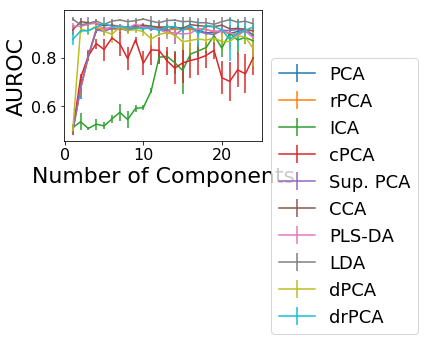

In [30]:
n_components_list = list(range(1, max_n_components))
n_iters = 5
n_methods = len(reduced)
results = np.zeros((n_methods, len(n_components_list), n_iters))
for n_iter in range(n_iters):
    for i, n_components in enumerate(n_components_list):
        print("N Components: {}".format(n_components))
        results[:, i, n_iter] = np.array(calc_predictive(n_components))

fig = plt.figure()
print("="*20)
print("Mean Case/Control AUC, Testing Data")
for i, (train, test, comps, name) in enumerate(reduced):
    if name == "Random":
        continue
    plt.errorbar(n_components_list, np.mean(results[i], axis=1), yerr=np.std(results[i], axis=1), label=name)
    print("{}:{:.3f}".format(name, np.mean(results[i])))
print("="*20)

plt.xlabel("Number of Components", fontsize=22)
plt.ylabel("AUROC", fontsize=22)
lgd = plt.legend(fontsize=18, bbox_to_anchor=(1, 0.7))
ax = plt.gca()
ax.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("{}/Results/aucroc_{}.png".format(cancer_type, fname_base), dpi=300,
    bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()